# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Инструкция по выполнению проекта

Чтобы усилить исследование, не ограничивайтесь градиентным бустингом. Попробуйте более простые модели — иногда они работают лучше. Эти редкие случаи легко пропустить, если всегда применять только бустинг.
Поэкспериментируйте и сравните характеристики моделей: время обучения, время предсказания, точность результата.

Основные шаги:

1. Загрузите данные, путь к файлу: /datasets/autos.csv.
2. Изучите данные. Заполните пропущенные значения и обработайте аномалии в столбцах. Если среди признаков имеются неинформативные, удалите их.
3. Подготовьте выборки для обучения моделей.
4. Обучите разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробуйте разные гиперпараметры.
5. Проанализируйте время обучения, время предсказания и качество моделей.
6. Опираясь на критерии заказчика, выберете лучшую модель, проверьте её качество на тестовой выборке.

Примечания:

* Для оценки качества моделей применяйте метрику RMSE.
* Значение метрики RMSE должно быть меньше 2500.
* Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга.
* Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найдите её.
* Модель градиентного бустинга может долго обучаться, поэтому измените у неё только два-три параметра.
* Если перестанет работать Jupyter Notebook, удалите лишние переменные оператором del.

```del features_train ```

## Подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, GridSearchCV

In [2]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

In [3]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


#### Признаки:

* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* Repaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

#### Целевой признак

* Price — цена (евро)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Присутствуют проспуски в колонках

In [5]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Цена не может быть 0 так как это целевой признак, избавимся от таких значений

In [6]:
(df['Price'] == 0).sum()

10772

In [7]:
df_filtr = df.query("Price > 0")

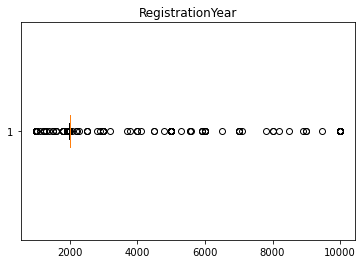

In [8]:
fig1, ax1 = plt.subplots()
ax1.set_title('RegistrationYear')
ax1.boxplot(df_filtr['RegistrationYear'],vert=False)
plt.show()

Очень много выбросов, нужно отфильтровать, во первых дата регистрации не может быть больше даты последнего скачивания.

Во вторых а\м старше 1980 г можно уже считать раритетом, по этому и оцениваются они совсем по другому.

In [9]:
(df['DateCrawled']).max()

'2016-04-07 14:36:58'

In [10]:
df_filtr = df_filtr.query("1980 < RegistrationYear  < 2017")

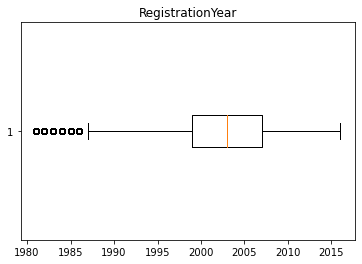

In [11]:
fig1, ax1 = plt.subplots()
ax1.set_title('RegistrationYear')
ax1.boxplot(df_filtr['RegistrationYear'],vert=False)
plt.show()

Вот уже похоже на нормальные данные

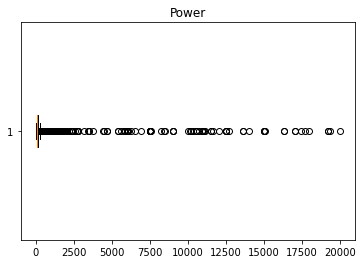

In [12]:
fig1, ax1 = plt.subplots()
ax1.set_title('Power')
ax1.boxplot(df_filtr['Power'],vert=False)
plt.show()

авто с количеством лошадиных сил 0 и более 1000 считаем ошибочными и выбросами

In [13]:
df_filtr = df_filtr.query("0 < Power  < 1000")

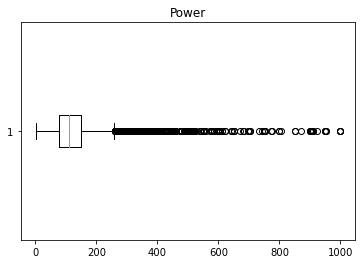

In [14]:
fig1, ax1 = plt.subplots()
ax1.set_title('Power')
ax1.boxplot(df_filtr['Power'],vert=False)
plt.show()

In [15]:
df_filtr['Power'].describe()

count    294156.000000
mean        120.882671
std          54.518322
min           1.000000
25%          77.000000
50%         111.000000
75%         150.000000
max         999.000000
Name: Power, dtype: float64

Так как неизвестна причина пропусков в VehicleType и Model, утасновим категорию unknown

In [16]:
df_filtr['VehicleType'] = df_filtr['VehicleType'].fillna(value="unknown")

In [17]:
df_filtr['Model'] = df_filtr['Model'].fillna(value="unknown")

пропуски в NotRepaired скорее всего связаны с тем что а\м не ремонтировался, заполним значения no

In [18]:
df_filtr['Repaired'] = df_filtr['Repaired'].fillna(value="no")

FuelType и Gearbox заполним частовстречающимися значениями.

In [19]:
df_filtr['FuelType']= df_filtr.groupby(['Brand', 'Model'])['FuelType'].transform(lambda x: x.fillna((x.mode()[0])))

In [20]:
df_filtr['Gearbox']= df_filtr.groupby(['Brand', 'Model'])['Gearbox'].transform(lambda x: x.fillna((x.mode()[0])))

In [21]:
df_filtr.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

В таблице есть колонки с не нужными данными для обучения, удалим их.

In [22]:
df_filtr = df_filtr.drop(columns=['DateCrawled', 'DateCreated', 'LastSeen', 
                                  'RegistrationMonth', 'PostalCode', 'NumberOfPictures'])

In [23]:
df_filtr.duplicated().sum()

47824

In [24]:
df_filtr = df_filtr.drop_duplicates().reset_index(drop=True)

In [25]:
df_filtr.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,18300,coupe,2011,manual,190,unknown,125000,gasoline,audi,yes
1,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,no
2,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
3,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
4,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes


In [26]:
df_oe = df_filtr
cat_list = {'VehicleType','Gearbox','Model','FuelType','Brand','Repaired'}
for cat in cat_list:
    df_oe[cat] = df_oe[cat].astype('category')
    df_oe[cat] = df_oe[cat].cat.codes
df_oe.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,18300,2,2011,1,190,226,125000,2,1,1
1,9800,6,2004,0,163,117,125000,2,14,0
2,1500,5,2001,1,75,116,150000,6,38,0
3,3600,5,2008,1,69,101,90000,2,31,0
4,650,4,1995,1,102,11,150000,6,2,1


In [27]:
#df_ohe = pd.get_dummies(df_oe, drop_first=True)
#df_ohe.head(5)

In [28]:
df_train, df_valid = train_test_split(df_oe, test_size=0.2, random_state=12345)


# выборка для теста
df_test_size = df_valid.shape[0] / df_train.shape[0]
df_train, df_test = train_test_split(df_train, test_size=df_test_size, random_state=12345)



numeric = ['RegistrationYear', 'Power', 'Kilometer']

# Признаки и таргеты
features_train = df_train.drop(['Price'], axis=1)
target_train = df_train['Price']

features_valid = df_valid.drop(['Price'], axis=1)
target_valid = df_valid['Price']

features_test = df_test.drop(['Price'], axis=1)
target_test = df_test['Price']

In [29]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

## Обучение моделей

Обучим следующие модели:

* LinearRegression
* DecisionTreeRegressor
* LGBMRegressor

In [30]:
test_score = {}

#### LinearRegression

In [31]:
%%time
line_reg_model = LinearRegression().fit(features_train, target_train)
predictions = line_reg_model.predict(features_train)
mse = mean_squared_error(target_train, predictions)
rmse_train = mse ** 0.5
print(rmse_train)

predictions_valid = line_reg_model.predict(features_valid)
mse_valid = mean_squared_error(target_valid, predictions_valid)
rmse_valid = mse_valid ** 0.5
print(rmse_valid)

2890.4264690156156
2912.499497705364
Wall time: 63.4 ms


In [32]:
%%time
predictions_test = line_reg_model.predict(features_test)
mse_test = mean_squared_error(target_test, predictions_test)
rmse_test = mse_valid ** 0.5
print(rmse_test)

2912.499497705364
Wall time: 10.3 ms


In [33]:
test_score['LinearRegression'] = [rmse_train, rmse_valid, rmse_test, '68.8 ms','4.99 ms']

#### DecisionTreeRegressor

In [34]:
%%time
for depth in np.arange(10, 20):
    regr = (DecisionTreeRegressor(max_depth=depth, random_state=12345)
        .fit(features_train, target_train)
       )
    predictions = regr.predict(features_train)
    mse = mean_squared_error(target_train, predictions)
    rmse_train = mse ** 0.5
    
    predictions_valid = regr.predict(features_valid)
    mse_valid = mean_squared_error(target_valid, predictions_valid)
    rmse_valid = mse_valid ** 0.5
    
    print("max_depth =", depth)
    print("Результат проверки на обучающей  выборке", rmse_train)
    print("Результат проверки на валидационной выборке", rmse_valid)
    print()

max_depth = 10
Результат проверки на обучающей  выборке 1871.5008652696674
Результат проверки на валидационной выборке 2005.791942026663

max_depth = 11
Результат проверки на обучающей  выборке 1770.3695249231362
Результат проверки на валидационной выборке 1954.9053260198925

max_depth = 12
Результат проверки на обучающей  выборке 1667.0346295750883
Результат проверки на валидационной выборке 1936.504928677655

max_depth = 13
Результат проверки на обучающей  выборке 1564.9716759558955
Результат проверки на валидационной выборке 1927.855418589528

max_depth = 14
Результат проверки на обучающей  выборке 1455.6945843605
Результат проверки на валидационной выборке 1924.5182143531752

max_depth = 15
Результат проверки на обучающей  выборке 1352.3595367744313
Результат проверки на валидационной выборке 1934.242095265498

max_depth = 16
Результат проверки на обучающей  выборке 1254.468362682985
Результат проверки на валидационной выборке 1956.7773758237452

max_depth = 17
Результат проверки н

In [35]:
%%time
regr = (DecisionTreeRegressor(max_depth=14, random_state=12345)
        .fit(features_train, target_train)
       )
predictions_test = regr.predict(features_test)
mse_test = mean_squared_error(target_test, predictions_test)
rmse_test = mse_test ** 0.5
print(rmse_test)

1922.9764034569794
Wall time: 468 ms


In [36]:
test_score['DecisionTreeRegressor'] = [rmse_train, rmse_valid, rmse_test, '3.84 s' , '349 ms']

При увеличение числа деревьев, модель переобучивается и качество предсказаний падает.

#### LGBMRegressor

In [37]:
kf = KFold(n_splits=5, shuffle=True, random_state=12345)

In [38]:
%%time
parameters = {'max_depth': np.arange(13, 15),
              'n_estimators': np.arange(37, 45)
             }

gs = GridSearchCV(LGBMRegressor(random_state=12345), 
                  parameters,
                  cv=kf,
                  scoring='neg_mean_squared_error')


gs.fit(features_train, target_train)

gs.best_params_

Wall time: 34.9 s


{'max_depth': 13, 'n_estimators': 44}

In [39]:
%%time
model_lgb = (LGBMRegressor(max_depth=13, 
                           n_estimators=44,
                           random_state=12345)
             .fit(features_train, target_train)
            )

predictions = model_lgb.predict(features_train)
mse = mean_squared_error(target_train, predictions)
rmse_train = mse ** 0.5
    
predictions_valid = model_lgb.predict(features_valid)
mse_valid = mean_squared_error(target_valid, predictions_valid)
rmse_valid = mse_valid ** 0.5

predictions_test = model_lgb.predict(features_test)
mse_test = mean_squared_error(target_test, predictions_test)
rmse_test = mse_test ** 0.5
rmse_test

Wall time: 582 ms


1805.134488171103

In [40]:
test_score['LGBMRegressor'] = [rmse_train, rmse_valid, rmse_test, '19.5 s' ,'531 ms']

## Анализ моделей

In [41]:
df_score = pd.DataFrame.from_dict(data=test_score, columns=['RMSE train', 'RMSE valid', 'RMSE test', 'Speed Train', 'Speed Test'], orient='index')
df_score

,RMSE train,RMSE valid,RMSE test,Speed Train,Speed Test
LinearRegression,2890.426469,2912.499498,2912.499498,68.8 ms,4.99 ms
DecisionTreeRegressor,1023.877956,2004.788461,1922.976403,3.84 s,349 ms
LGBMRegressor,1779.359975,1816.233659,1805.134488,19.5 s,531 ms


<AxesSubplot:>

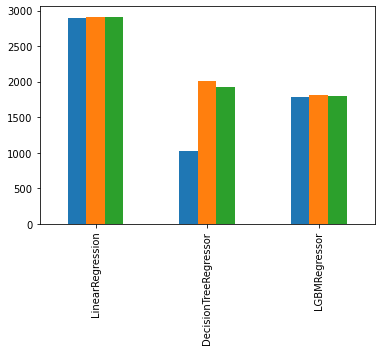

In [42]:
df_score.plot(kind='bar', legend=False)

Модель LinearRegression обучается и предсказывает быстрее всех, но имеет и максимальное отклонение в предсказании.

DecisionTreeRegressor обучается достаточно быстро, но на тестовой выборке показатель предсказания сильно падает.

Модель LGBMRegressor долго обучается, но имеет лучшие показатели предсказания.

С учетом пожеланий заказчика можно предложить модель DecisionTreeRegressor она не на много сильнее ошибается чем LGBMRegressor, обучается в разы быстрее. 